# Yelp Dataset

## Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

try:
  train_df = pd.read_csv('/content/drive/MyDrive/yelp_dataset/train.csv', names=['label', 'text'], header=None)
  test_df = pd.read_csv('/content/drive/MyDrive/yelp_dataset/test.csv', names=['label', 'text'], header=None)
  print("Files loaded successfully.")
except FileNotFoundError:
  print("Error: One or both files not found in the specified location. Check the file paths.")
except pd.errors.ParserError:
  print("Error: Could not parse the CSV files. Check their format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files loaded successfully.


In [ ]:
train_subset = pd.concat([
    train_df[train_df.label == 1].sample(10000, random_state=42),  # Negative class
    train_df[train_df.label == 2].sample(10000, random_state=42)   # Positive class
])


In [ ]:
test_subset = pd.concat([
    test_df[test_df.label == 1].sample(1000, random_state=42),
    test_df[test_df.label == 2].sample(1000, random_state=42)
])

In [ ]:
train_subset = train_subset.sample(frac=1, random_state=42).reset_index(drop=True)
test_subset = test_subset.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_subset['label'] = train_subset['label'].replace({1:0, 2:1})
test_subset['label'] = test_subset['label'].replace({1:0, 2:1})

In [ ]:
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Prepprocessing steps:


1.   Replacing special characters
2.   Remove punctuation and numbers
3.   Case folding
4.   Tokenization
5.   Stop word removal
6.   Lemmatization



In [ ]:
def preprocess(text):
    text = text.replace('\\"', ' ').replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very'}
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

In [ ]:
# Apply preprocessing
train_subset['processed'] = train_subset['text'].apply(preprocess)
test_subset['processed'] = test_subset['text'].apply(preprocess)

## Word2vec and Tokenization

In [ ]:
#!pip install gensim

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(
    sentences=train_subset['processed'].tolist(),
    vector_size=300,
    window=5,
    min_count=5,
    workers=2,
    epochs=5
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_subset['processed'])

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_subset['processed']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_subset['processed']), maxlen=100)

In [ ]:
import numpy as np

In [ ]:
embedding_matrix = np.zeros((20000, 300))
for word, i in tokenizer.word_index.items():
    if i < 20000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

## Model Training and Evaluation (bi-LSTM). Best val_acc = 0.9150 (Yelp)

In [ ]:
from sklearn.model_selection import train_test_split

y_train = train_subset['label'].values
y_test = test_subset['label'].values

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
import numpy as np
import time
from tensorflow.keras.regularizers import l2

In [ ]:
def create_model(lstm_units, dropout_rate, lr, embedding_matrix, l2_lambda=1e-4):
    input_ = Input(shape=(100,))
    x = Embedding(input_dim=20000, output_dim=300, weights=[embedding_matrix], trainable=False)(input_)
    x = Bidirectional(LSTM(units=lstm_units, return_sequences=False,
                           kernel_regularizer=l2(l2_lambda),
                           recurrent_regularizer=l2(l2_lambda)))(x)
    x = Dropout(rate=dropout_rate)(x)
    output = Dense(1, activation='sigmoid', dtype='float32',
                   kernel_regularizer=l2(l2_lambda))(x)
    model = Model(inputs=input_, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

In [ ]:
# Searching through all combinations, finding best ones.
# For initial units, after first fun, focus on best parameter, and search through new set of intial units (taking range +-10 from best hyperparameter of first run)
#

def search_lstm_hyperparams(X_train_part, y_train_part, X_val, y_val, embedding_matrix,
                             initial_units=[50, 100, 150], zoom_range=10, max_zoom_depth=2):
    all_results = []
    best_overall = None
    seen_configs = set()
    zoom_depth = 0
    best_accuracy = 0

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    while zoom_depth <= max_zoom_depth:
        print(f"Zoom Level {zoom_depth} - Searching units: {initial_units}")
        for lstm_units, dropout_rate, lr, batch_size in product(initial_units, [0.3, 0.5], [1e-4, 3e-4, 1e-3], [32, 64]):
            # skip repeating combinations
            config_key = (lstm_units, dropout_rate, lr, batch_size)
            if config_key in seen_configs:
                continue
            seen_configs.add(config_key)

            print(f"Trying units={lstm_units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")
            model = create_model(lstm_units, dropout_rate, lr, embedding_matrix)
            start_time = time.time()
            history = model.fit(
                X_train_part, y_train_part,
                validation_data=(X_val, y_val),
                epochs=20,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=0
            )
            elapsed = time.time() - start_time
            val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

            all_results.append((val_acc, lstm_units, dropout_rate, lr, batch_size, elapsed, model))

            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_overall = (val_acc, lstm_units, dropout_rate, lr, batch_size, elapsed, model)

        best_units = best_overall[1]
        initial_units = list(sorted(set([
            max(10, best_units - zoom_range),
            best_units,
            best_units + zoom_range
        ])))
        zoom_depth += 1

    return best_overall, all_results


In [ ]:
best_model_info, all_trials = search_lstm_hyperparams(
    X_train_part, y_train_part,
    X_val, y_val,
    embedding_matrix
)

Zoom Level 0 - Searching units: [50, 100, 150]
Trying units=50, dropout=0.3, lr=0.0001, batch_size=32
Trying units=50, dropout=0.3, lr=0.0001, batch_size=64
Trying units=50, dropout=0.3, lr=0.0003, batch_size=32
Trying units=50, dropout=0.3, lr=0.0003, batch_size=64
Trying units=50, dropout=0.3, lr=0.001, batch_size=32
Trying units=50, dropout=0.3, lr=0.001, batch_size=64
Trying units=50, dropout=0.5, lr=0.0001, batch_size=32
Trying units=50, dropout=0.5, lr=0.0001, batch_size=64
Trying units=50, dropout=0.5, lr=0.0003, batch_size=32
Trying units=50, dropout=0.5, lr=0.0003, batch_size=64
Trying units=50, dropout=0.5, lr=0.001, batch_size=32
Trying units=50, dropout=0.5, lr=0.001, batch_size=64
Trying units=100, dropout=0.3, lr=0.0001, batch_size=32
Trying units=100, dropout=0.3, lr=0.0001, batch_size=64
Trying units=100, dropout=0.3, lr=0.0003, batch_size=32
Trying units=100, dropout=0.3, lr=0.0003, batch_size=64
Trying units=100, dropout=0.3, lr=0.001, batch_size=32
Trying units=100, 

In [ ]:
val_acc, units, drop, lr, batch, time_taken, best_model = best_model_info
print(f"Best Model: val_acc={val_acc:.4f}, units={units}, dropout={drop}, lr={lr}, batch={batch}")

Best Model: val_acc=0.9150, units=100, dropout=0.5, lr=0.001, batch=64


In [ ]:
start_eval = time.time()
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
end_eval = time.time()

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Best evaluation time: {end_eval - start_eval:.2f} seconds")

Test Accuracy: 0.9110
est evaluation time: 0.45 seconds


In [ ]:
results_df = pd.DataFrame(all_trials, columns=['val_acc', 'lstm_units', 'dropout', 'lr', 'batch', 'time_taken', 'model'])
results_df.drop(columns=['model']).to_csv("bi_lstm_search_results.csv", index=False)

In [ ]:
import seaborn as sns

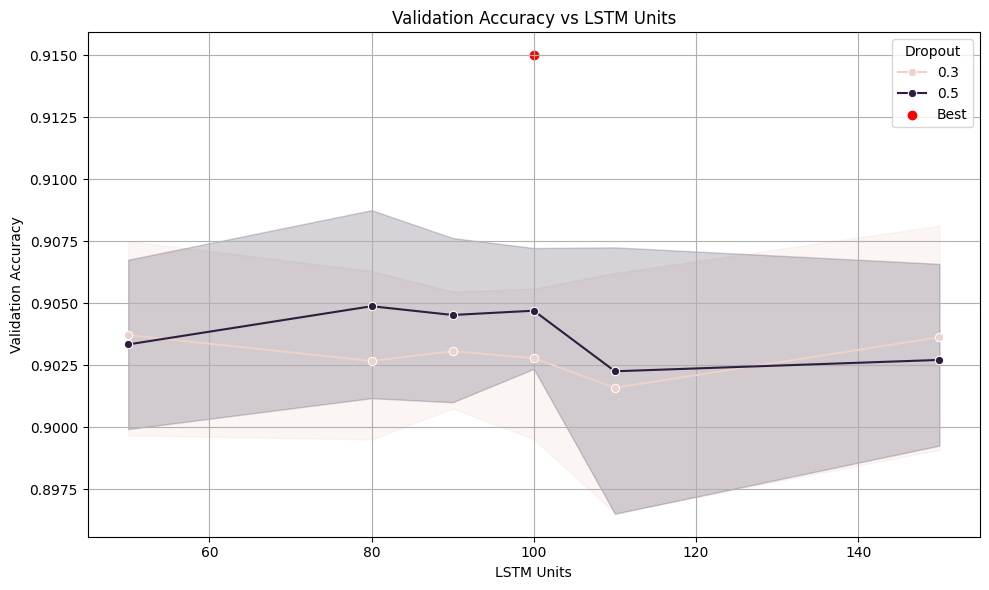

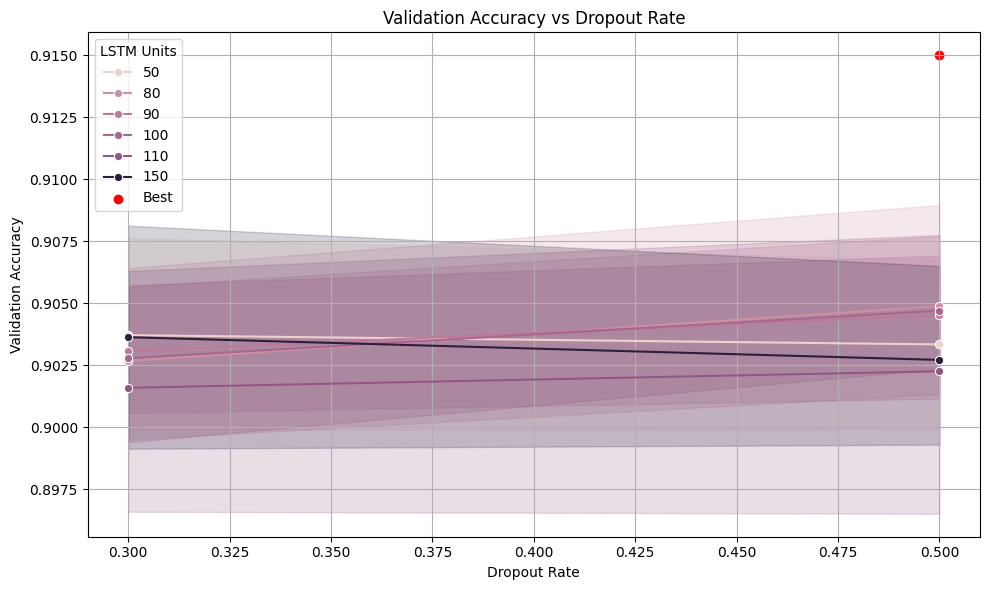

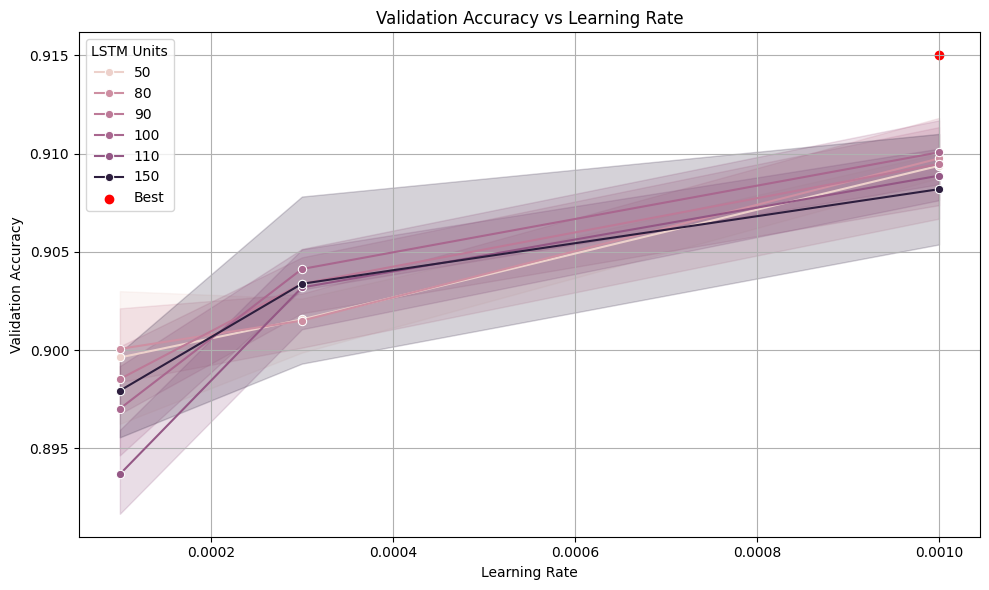

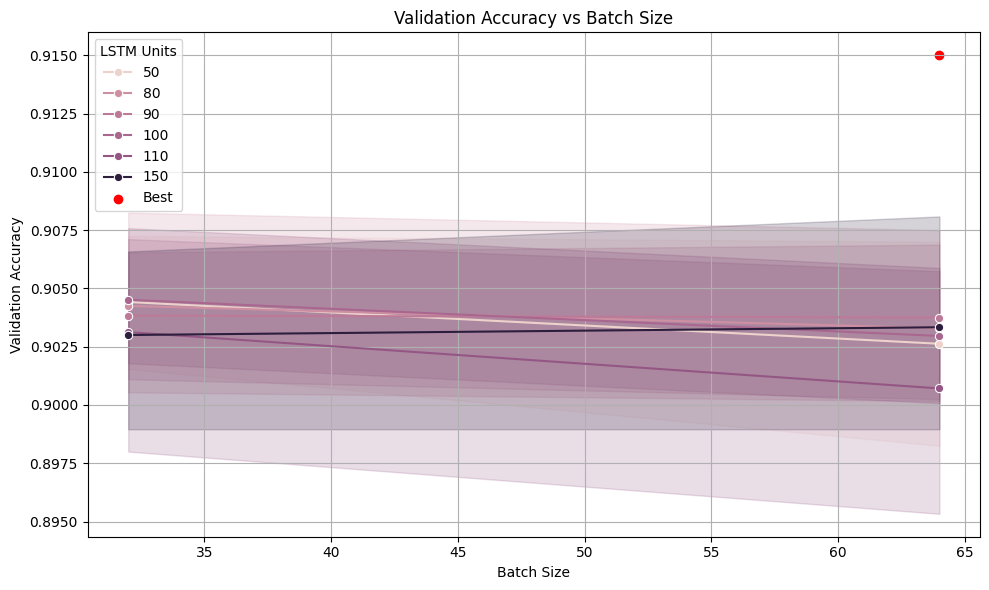

In [ ]:
best_row = results_df.loc[results_df['val_acc'].idxmax()]

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='lstm_units', y='val_acc', hue='dropout', marker='o')
plt.scatter(best_row['lstm_units'], best_row['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs LSTM Units")
plt.xlabel("LSTM Units")
plt.ylabel("Validation Accuracy")
plt.legend(title='Dropout')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='dropout', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row['dropout'], best_row['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='lr', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row['lr'], best_row['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='batch', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row['batch'], best_row['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_, best_units, best_dropout, best_lr, best_batch, _, _ = best_model_info

In [ ]:
model_yelp = create_model(best_units, best_dropout, best_lr, embedding_matrix, l2_lambda=1e-4)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model_yelp.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=best_batch,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8028 - loss: 0.4829 - val_accuracy: 0.8820 - val_loss: 0.3247
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8876 - loss: 0.3127 - val_accuracy: 0.8863 - val_loss: 0.3096
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8994 - loss: 0.2817 - val_accuracy: 0.8920 - val_loss: 0.2878
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9079 - loss: 0.2563 - val_accuracy: 0.8873 - val_loss: 0.2872
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9169 - loss: 0.2381 - val_accuracy: 0.9032 - val_loss: 0.2679
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9209 - loss: 0.2308 - val_accuracy: 0.8997 - val_loss: 0.2687
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9296 - loss: 0.2123 - val_accuracy: 0.9022 - val_loss: 0.2761
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9294 - loss: 0.2054 - val_accu

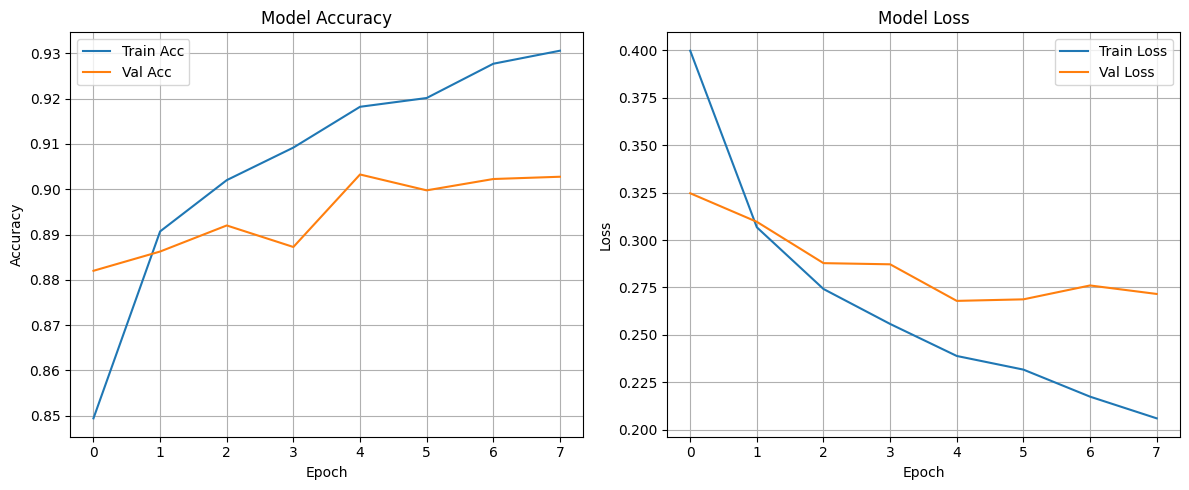

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Training and Evaluation (CNN). Best val_acc = 0.9082 (Yelp)

In [ ]:
def create_cnn_model(filters, kernel_size, dropout_rate, lr, embedding_matrix, l2_lambda=1e-4):
    input_ = Input(shape=(100,))
    x = Embedding(input_dim=20000, output_dim=300, weights=[embedding_matrix], trainable=False)(input_)
    x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
               kernel_regularizer=l2(l2_lambda))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=dropout_rate)(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))(x)
    model = Model(inputs=input_, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model

In [ ]:
# Same searching strategy as for the bi-lstm case, but with changed hyperparameters. Focus on number of filters

def search_cnn_hyperparams(X_train_part, y_train_part, X_val, y_val, embedding_matrix,
                                initial_filters=[64, 128, 256], zoom_range=10, max_zoom_depth=2,
                                kernel_sizes=[3, 5], dropout_grid=[0.3, 0.5], lr_grid=[1e-4, 3e-4, 1e-3],
                                batch_grid=[32, 64]):
    all_results = []
    best_overall = None
    best_accuracy = 0
    seen_configs = set()
    zoom_depth = 0

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=1e-4, mode='min')

    while zoom_depth <= max_zoom_depth:
        print(f"Zoom Level {zoom_depth} - Searching filters: {initial_filters}")
        for filters, kernel_size, dropout_rate, lr, batch_size in product(initial_filters, kernel_sizes, dropout_grid, lr_grid, batch_grid):
            config_key = (filters, kernel_size, dropout_rate, lr, batch_size)
            if config_key in seen_configs:
                continue
            seen_configs.add(config_key)

            print(f"Trying filters={filters}, kernel={kernel_size}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")
            model = create_cnn_model(filters, kernel_size, dropout_rate, lr, embedding_matrix)
            start_time = time.time()
            history = model.fit(
                X_train_part, y_train_part,
                validation_data=(X_val, y_val),
                epochs=20,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=0
            )
            elapsed = time.time() - start_time
            val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

            all_results.append((val_acc, filters, kernel_size, dropout_rate, lr, batch_size, elapsed, model))

            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_overall = (val_acc, filters, kernel_size, dropout_rate, lr, batch_size, elapsed, model)

        best_filters = best_overall[1]
        initial_filters = list(sorted(set([
            max(16, best_filters - zoom_range),
            best_filters,
            best_filters + zoom_range
        ])))
        zoom_depth += 1

    return best_overall, all_results

In [ ]:
best_cnn_model_info, cnn_trials = search_cnn_hyperparams(X_train_part, y_train_part, X_val, y_val, embedding_matrix)

Zoom Level 0 - Searching filters: [64, 128, 256]
Trying filters=64, kernel=3, dropout=0.3, lr=0.0001, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.0001, batch_size=64
Trying filters=64, kernel=3, dropout=0.3, lr=0.0003, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.0003, batch_size=64
Trying filters=64, kernel=3, dropout=0.3, lr=0.001, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.001, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.0001, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.0001, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.0003, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.0003, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.001, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.001, batch_size=64
Trying filters=64, kernel=5, dropout=0.3, lr=0.0001, batch_size=32
Trying filters=64, kernel=5, dropout=0.3, lr=0.0001, batch_size=64
Trying filters=64

In [ ]:
results_df_cnn_yelp = pd.DataFrame(cnn_trials, columns=['val_acc', 'filters', 'kernel_size', 'dropout', 'lr', 'batch', 'time_taken', 'model'])
results_df_cnn_yelp.drop(columns=['model']).to_csv("cnn_sentiment_results_yelp.csv", index=False)

In [ ]:
val_acc, filters, kernel_size, dropout, lr, batch, time_taken, best_model = best_cnn_model_info
print(f"Best val_acc = {val_acc:.4f}")

Best val_acc = 0.9082


In [ ]:
best_row_cnn_yelp = results_df_cnn_yelp.loc[results_df_cnn_yelp['val_acc'].idxmax()]

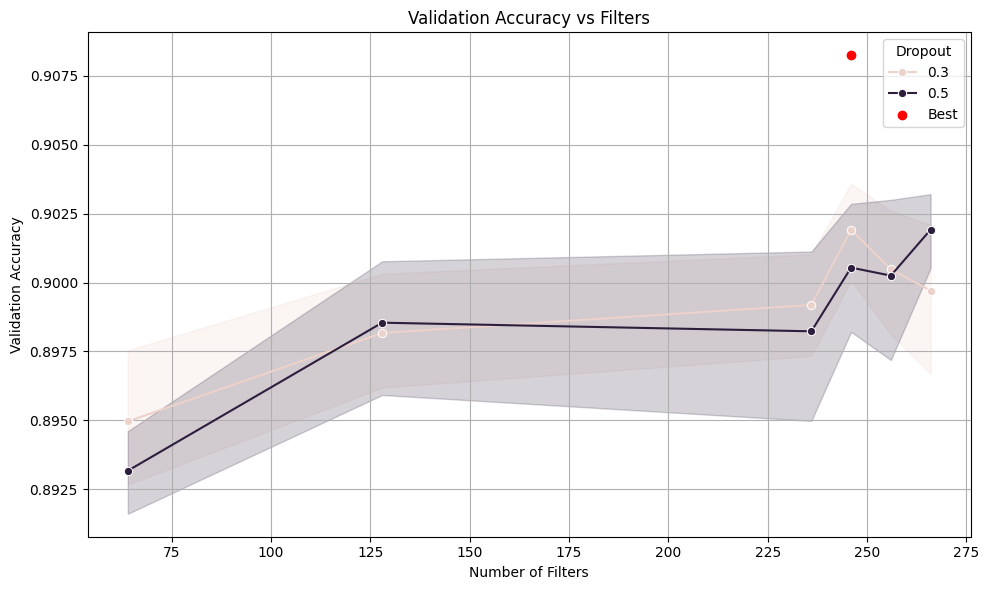

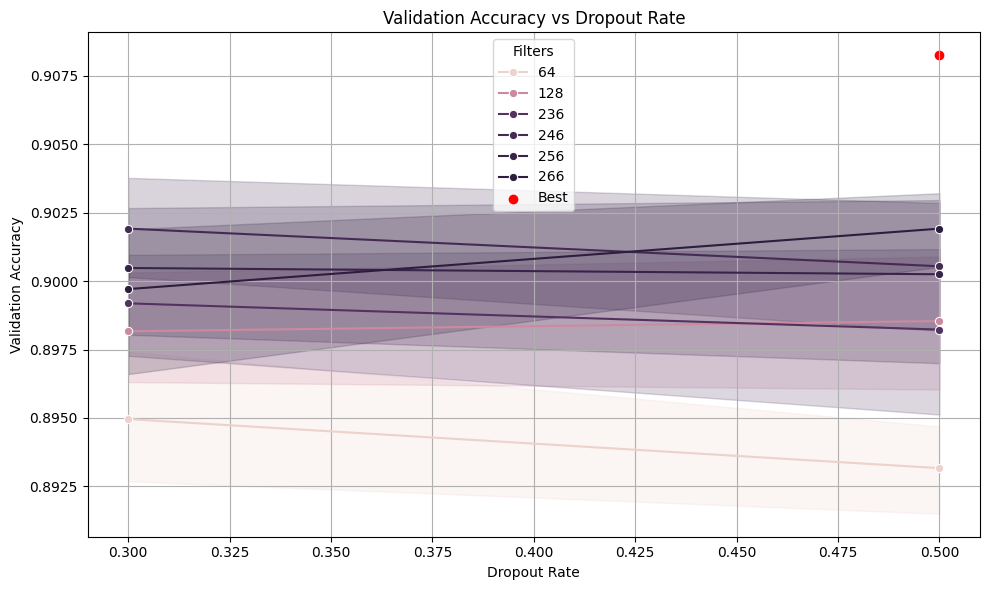

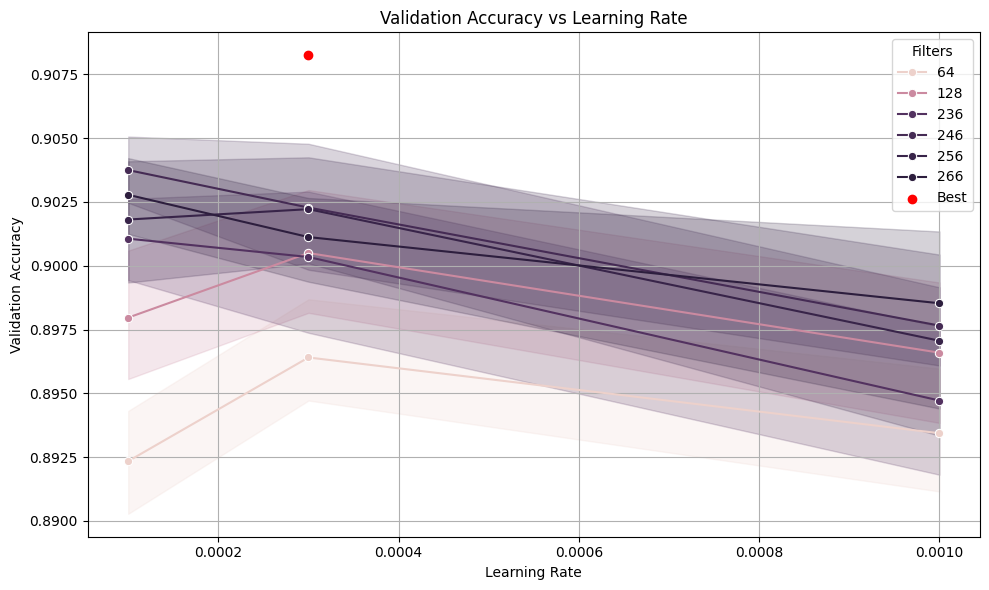

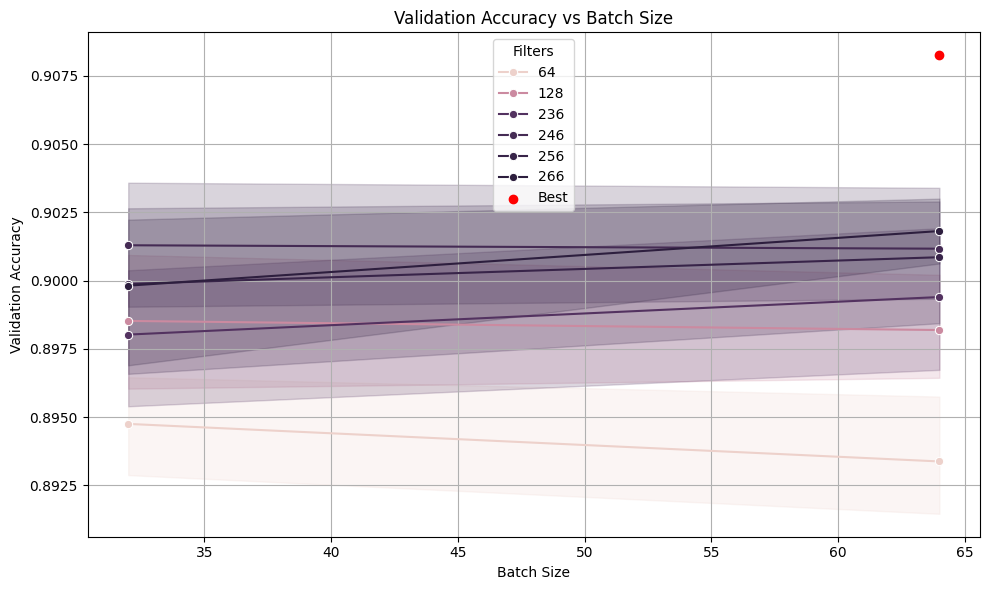

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_cnn_yelp, x='filters', y='val_acc', hue='dropout', marker='o')
plt.scatter(best_row_cnn_yelp['filters'], best_row_cnn_yelp['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Filters")
plt.xlabel("Number of Filters")
plt.ylabel("Validation Accuracy")
plt.legend(title='Dropout')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Dropout
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_cnn_yelp, x='dropout', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_yelp['dropout'], best_row_cnn_yelp['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Learning Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_cnn_yelp, x='lr', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_yelp['lr'], best_row_cnn_yelp['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Batch Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_cnn_yelp, x='batch', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_yelp['batch'], best_row_cnn_yelp['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
val_acc, filters, kernel_size, dropout, lr, batch, _, _ = best_cnn_model_info

In [ ]:
model_cnn_yelp = create_cnn_model(filters, kernel_size, dropout, lr, embedding_matrix)

In [ ]:
history = model_cnn_yelp.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=batch,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7089 - loss: 0.6345 - val_accuracy: 0.8645 - val_loss: 0.3411
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8526 - loss: 0.3621 - val_accuracy: 0.8808 - val_loss: 0.3154
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8772 - loss: 0.3121 - val_accuracy: 0.8838 - val_loss: 0.3000
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8914 - loss: 0.2857 - val_accuracy: 0.8860 - val_loss: 0.2939
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8977 - loss: 0.2719 - val_accuracy: 0.8900 - val_loss: 0.2846
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9082 - loss: 0.2545 - val_accuracy: 0.8910 - val_loss: 0.2795
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9095 - loss: 0.2495 - val_accuracy: 0.8928 - val_loss: 0.2780
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9156 - loss: 0.2415 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model_cnn_yelp.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy on Yelp Dataset: {test_acc:.4f}")

Test Accuracy on Yelp Dataset: 0.8985


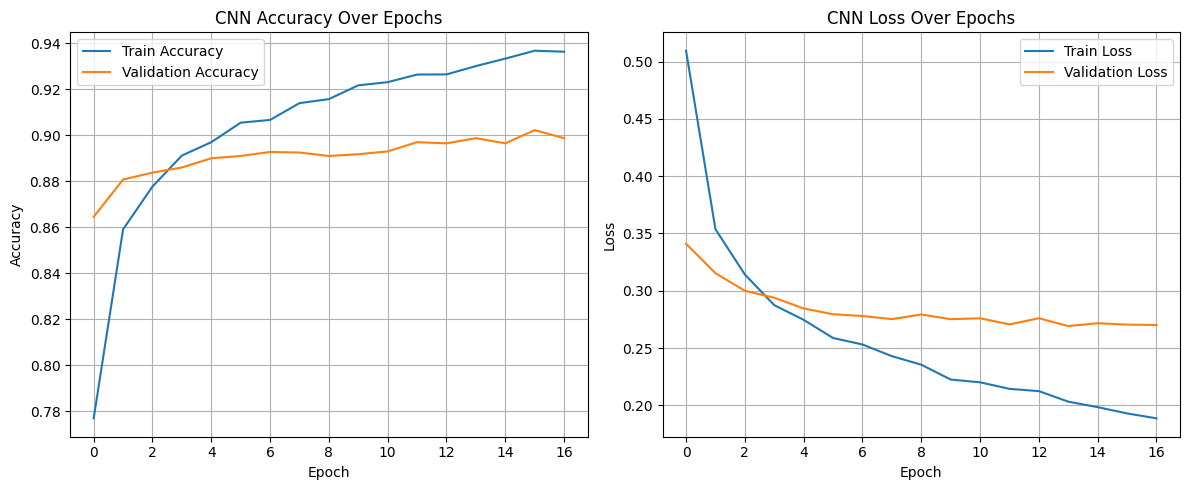

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Amazon Fine Food Reviews Dataset

## Preprocessing

In [ ]:
amazon_df = pd.read_pickle("/content/drive/MyDrive/amazon/processed_reviews.pkl")
amazon_df = amazon_df.rename(columns={'Combo': 'text', 'Score': 'label'})
print(amazon_df.head())

                                                text  label
0  ick save your money i just bought a keurig and...      0
1  nasty animal hair in marrobones my dog loves m...      0
2  don t be fooled by the packaging this tea is u...      0
3  horrible i ll stick with swanson s this has a ...      0
4  coffee bean direct papua new guinea city roast...      0


In [ ]:
print("Unique sentiment labels:", sorted(amazon_df['label'].unique()))

Unique sentiment labels: [0, 1, 2, 3, 4]


In [ ]:
label_counts = amazon_df['label'].value_counts().sort_index()
print("Class distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Class distribution:
Label 0: 15000 samples
Label 1: 15000 samples
Label 2: 15000 samples
Label 3: 15000 samples
Label 4: 15000 samples


In [ ]:
# filtering out neutral class
amazon_df = amazon_df[amazon_df['label'] != 2]

In [ ]:
# mapping to new classes
amazon_df['label'] = amazon_df['label'].map(lambda x: 0 if x < 2 else 1)

In [ ]:
print("Class distribution after binarization:")
print(amazon_df['label'].value_counts())

Class distribution after binarization:
label
0    30000
1    30000
Name: count, dtype: int64


In [ ]:
def preprocess(text):
    text = text.replace('\\"', ' ').replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very'}
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

amazon_df['processed'] = amazon_df['text'].apply(preprocess)

## Word2Vec and Tokenization

In [ ]:
w2v_model = Word2Vec(
    sentences=amazon_df['processed'].tolist(),
    vector_size=300,
    window=5,
    min_count=5,
    workers=2,
    epochs=5
)

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(amazon_df['processed'])

In [ ]:
X = pad_sequences(tokenizer.texts_to_sequences(amazon_df['processed']), maxlen=100)
y = amazon_df['label'].values

In [ ]:
embedding_matrix = np.zeros((20000, 300))
for word, i in tokenizer.word_index.items():
    if i < 20000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_amazon, X_test_amazon, y_train_amazon, y_test_amazon = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Model Training and Evaluation (bi-LSTM). Best val_acc = 0.9050 (Amazon)

In [ ]:
best_model_info, all_trials = search_lstm_hyperparams(
    X_train_part, y_train_part,
    X_val, y_val,
    embedding_matrix
)

Zoom Level 0 - Searching units: [50, 100, 150]
Trying units=50, dropout=0.3, lr=0.0001, batch_size=32
Trying units=50, dropout=0.3, lr=0.0001, batch_size=64
Trying units=50, dropout=0.3, lr=0.0003, batch_size=32
Trying units=50, dropout=0.3, lr=0.0003, batch_size=64
Trying units=50, dropout=0.3, lr=0.001, batch_size=32
Trying units=50, dropout=0.3, lr=0.001, batch_size=64
Trying units=50, dropout=0.5, lr=0.0001, batch_size=32
Trying units=50, dropout=0.5, lr=0.0001, batch_size=64
Trying units=50, dropout=0.5, lr=0.0003, batch_size=32
Trying units=50, dropout=0.5, lr=0.0003, batch_size=64
Trying units=50, dropout=0.5, lr=0.001, batch_size=32
Trying units=50, dropout=0.5, lr=0.001, batch_size=64
Trying units=100, dropout=0.3, lr=0.0001, batch_size=32
Trying units=100, dropout=0.3, lr=0.0001, batch_size=64
Trying units=100, dropout=0.3, lr=0.0003, batch_size=32
Trying units=100, dropout=0.3, lr=0.0003, batch_size=64
Trying units=100, dropout=0.3, lr=0.001, batch_size=32
Trying units=100, 

In [ ]:
results_df2 = pd.DataFrame(all_trials, columns=['val_acc', 'lstm_units', 'dropout', 'lr', 'batch', 'time_taken', 'model'])
results_df2.drop(columns=['model']).to_csv("amazon_bilstm_results.csv", index=False)

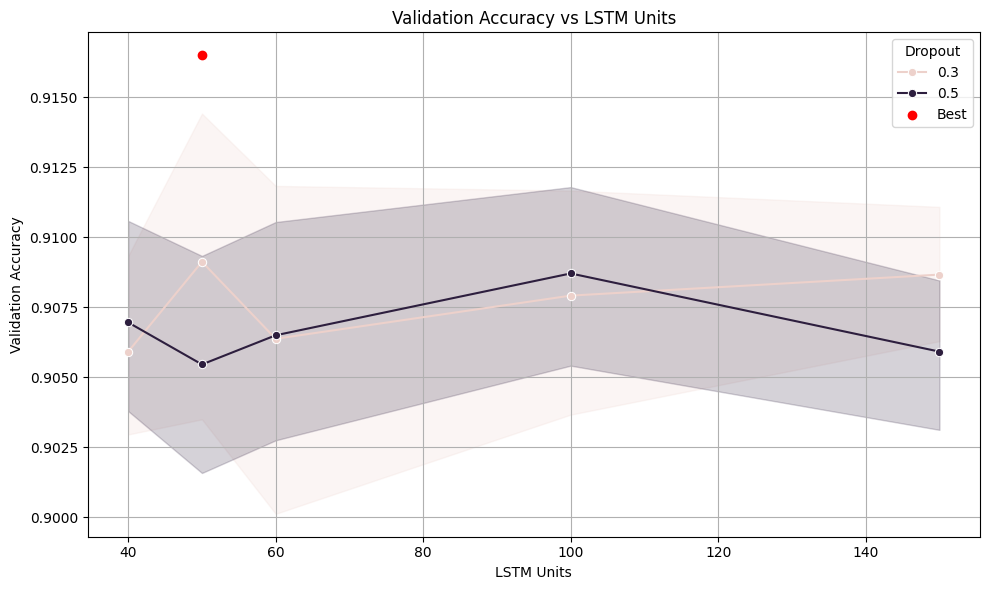

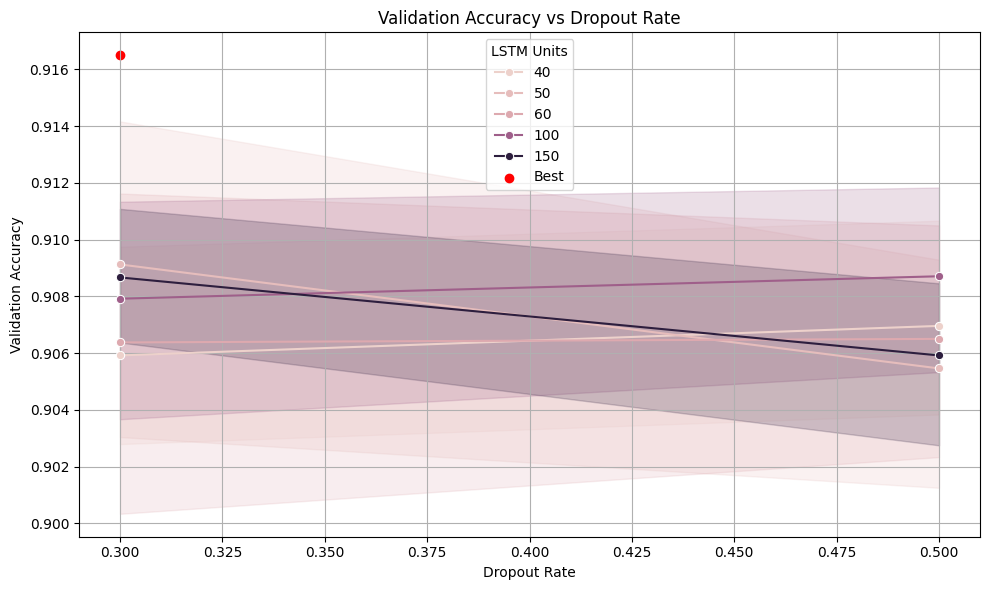

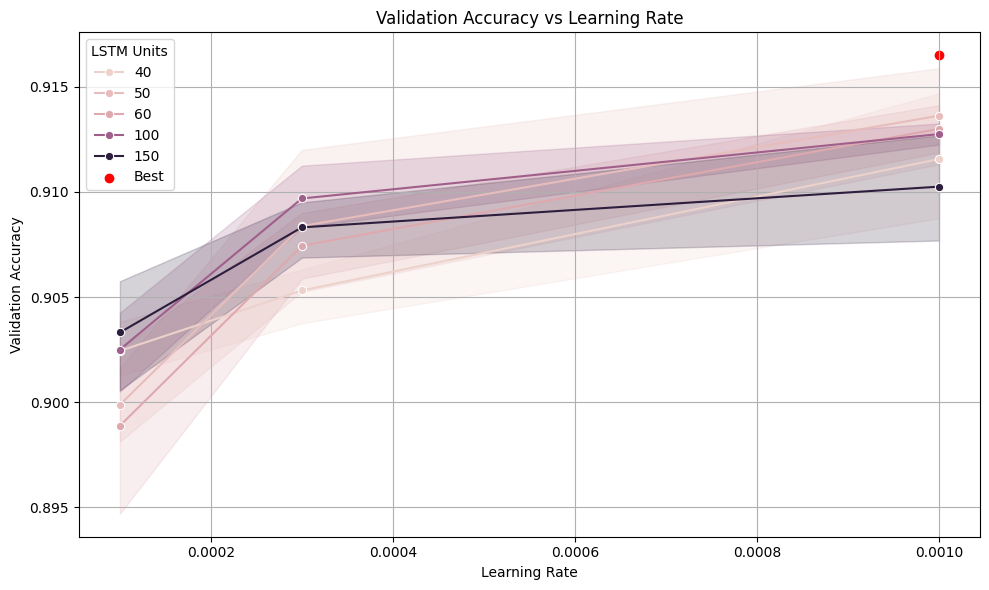

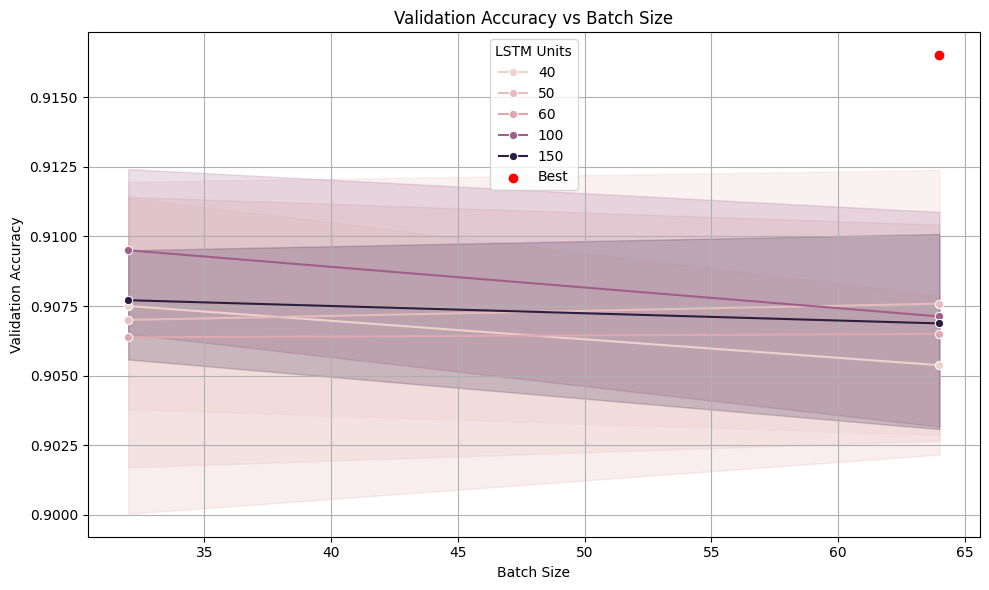

In [ ]:
import seaborn as sns
best_row2 = results_df2.loc[results_df2['val_acc'].idxmax()]

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df2, x='lstm_units', y='val_acc', hue='dropout', marker='o')
plt.scatter(best_row2['lstm_units'], best_row2['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs LSTM Units")
plt.xlabel("LSTM Units")
plt.ylabel("Validation Accuracy")
plt.legend(title='Dropout')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df2, x='dropout', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row2['dropout'], best_row2['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df2, x='lr', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row2['lr'], best_row2['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df2, x='batch', y='val_acc', hue='lstm_units', marker='o')
plt.scatter(best_row2['batch'], best_row2['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.legend(title='LSTM Units')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_model = best_model_info[-1]

import time
start = time.time()
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
end = time.time()

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Evaluation Time: {end - start:.2f} sec")

Test Accuracy: 0.9050
Evaluation Time: 0.48 sec


In [ ]:
_, best_units, best_dropout, best_lr, best_batch, _, _ = best_model_info

In [ ]:
model_amazon = create_model(best_units, best_dropout, best_lr, embedding_matrix, l2_lambda=1e-4)

In [ ]:
history = model_amazon.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=best_batch,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7889 - loss: 0.4932 - val_accuracy: 0.8708 - val_loss: 0.3428
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8849 - loss: 0.3214 - val_accuracy: 0.8898 - val_loss: 0.2930
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8946 - loss: 0.2885 - val_accuracy: 0.8870 - val_loss: 0.3047
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9112 - loss: 0.2555 - val_accuracy: 0.8997 - val_loss: 0.2732
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9225 - loss: 0.2308 - val_accuracy: 0.8917 - val_loss: 0.2912
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9176 - loss: 0.2349 - val_accuracy: 0.8978 - val_loss: 0.2880
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9282 - loss: 0.2163 - val_accuracy: 0.9043 - val_loss: 0.2787


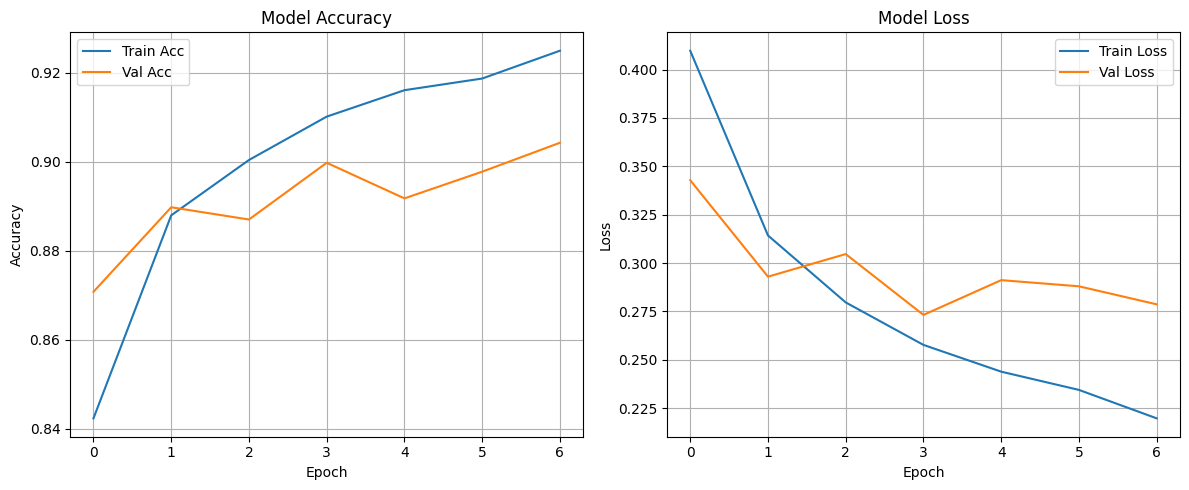

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Training and evaluation (CNN). Best val_acc = 0.8925 (Amazon)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_amazon, X_val_amazon, y_train_amazon, y_val_amazon = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
best_cnn_model_info_amazon, cnn_trials_amazon = search_cnn_hyperparams(
    X_train_amazon, y_train_amazon,
    X_val_amazon, y_val_amazon,
    embedding_matrix
)

Zoom Level 0 - Searching filters: [64, 128, 256]
Trying filters=64, kernel=3, dropout=0.3, lr=0.0001, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.0001, batch_size=64
Trying filters=64, kernel=3, dropout=0.3, lr=0.0003, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.0003, batch_size=64
Trying filters=64, kernel=3, dropout=0.3, lr=0.001, batch_size=32
Trying filters=64, kernel=3, dropout=0.3, lr=0.001, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.0001, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.0001, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.0003, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.0003, batch_size=64
Trying filters=64, kernel=3, dropout=0.5, lr=0.001, batch_size=32
Trying filters=64, kernel=3, dropout=0.5, lr=0.001, batch_size=64
Trying filters=64, kernel=5, dropout=0.3, lr=0.0001, batch_size=32
Trying filters=64, kernel=5, dropout=0.3, lr=0.0001, batch_size=64
Trying filters=64

In [ ]:
results_df_amazon_cnn = pd.DataFrame(cnn_trials_amazon, columns=[
    'val_acc', 'filters', 'kernel_size', 'dropout', 'lr', 'batch', 'time_taken', 'model'
])
results_df_amazon_cnn.drop(columns=['model']).to_csv("amazon_cnn_results.csv", index=False)

In [ ]:
val_acc, filters, kernel_size, dropout, lr, batch, time_taken, best_model = best_cnn_model_info_amazon
print(f"Best val_acc = {val_acc:.4f}")


model_amazon_cnn = create_cnn_model(filters, kernel_size, dropout, lr, embedding_matrix)

history = model_amazon_cnn.fit(
    X_train_amazon, y_train_amazon,
    validation_split=0.2,
    epochs=20,
    batch_size=batch,
    callbacks=[early_stop],
    verbose=1
)

Best val_acc = 0.8925
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5951 - loss: 0.8958 - val_accuracy: 0.8081 - val_loss: 0.4450
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7583 - loss: 0.5304 - val_accuracy: 0.8406 - val_loss: 0.3940
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8083 - loss: 0.4451 - val_accuracy: 0.8525 - val_loss: 0.3730
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8386 - loss: 0.3861 - val_accuracy: 0.8566 - val_loss: 0.3574
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8610 - loss: 0.3536 - val_accuracy: 0.8622 - val_loss: 0.3473
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.3212 - val_accuracy: 0.8631 - val_loss: 0.3453
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8857 - loss: 0.3077 - val_accuracy: 0.8659 - val_loss: 0.3348
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8909 - loss: 0.2

In [ ]:
test_loss, test_acc = model_amazon_cnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy on Amazon Dataset: {test_acc:.4f}")

Test Accuracy on Amazon Dataset: 0.8850


In [ ]:
best_row_cnn_amazon = results_df_amazon_cnn.loc[results_df_amazon_cnn['val_acc'].idxmax()]

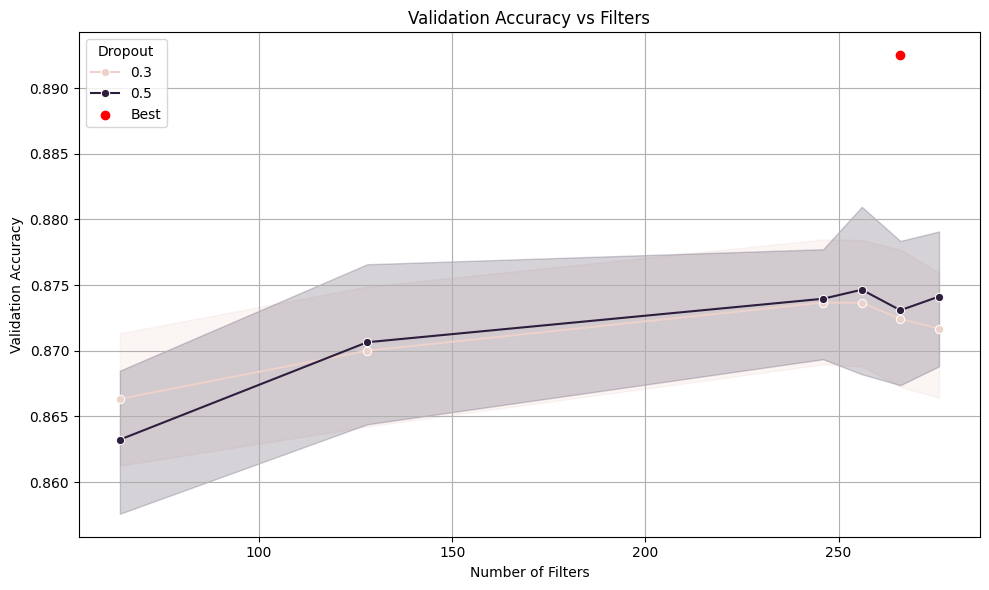

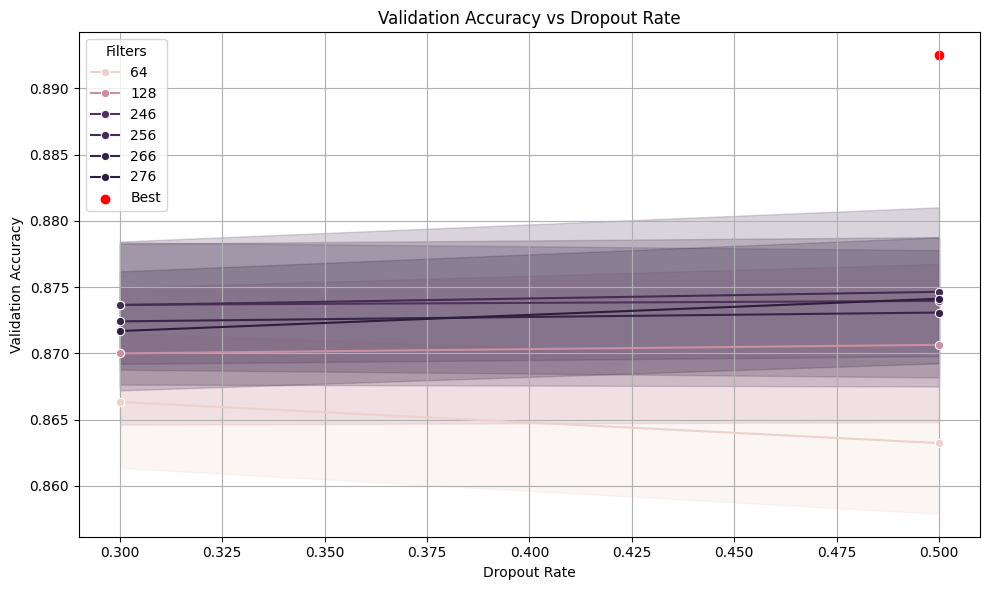

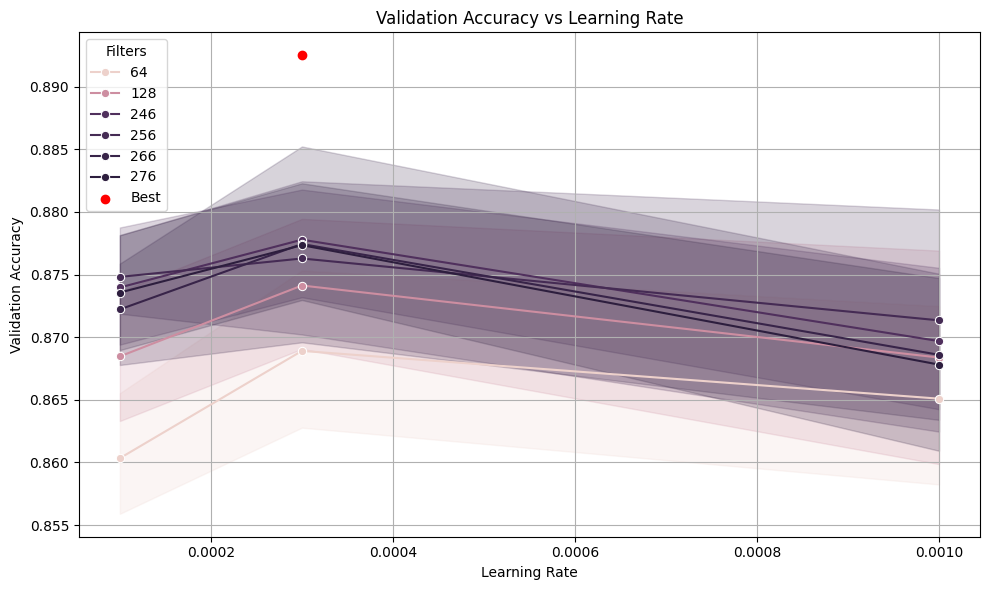

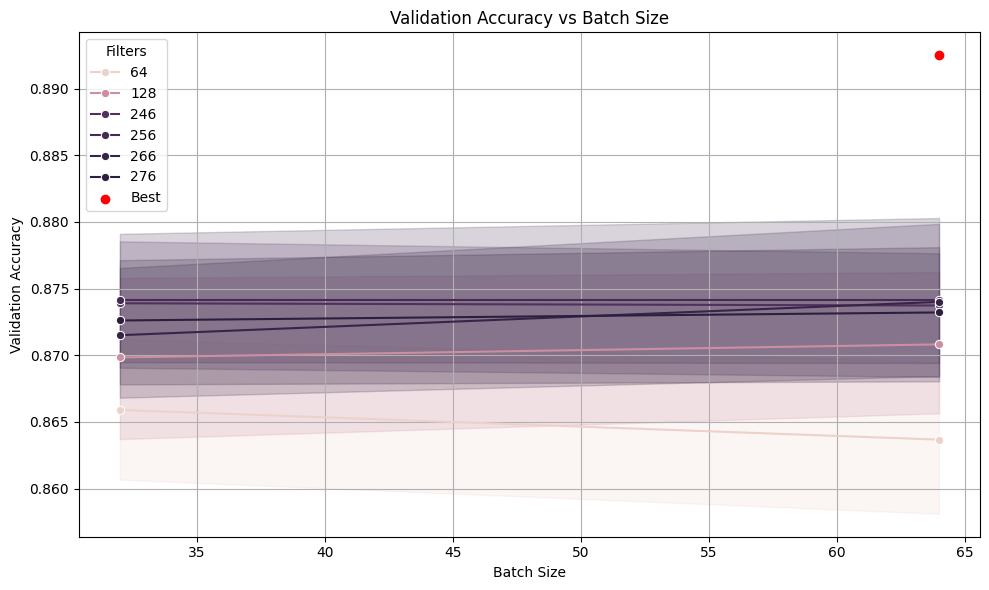

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_amazon_cnn, x='filters', y='val_acc', hue='dropout', marker='o')
plt.scatter(best_row_cnn_amazon['filters'], best_row_cnn_amazon['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Filters")
plt.xlabel("Number of Filters")
plt.ylabel("Validation Accuracy")
plt.legend(title='Dropout')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Dropout
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_amazon_cnn, x='dropout', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_amazon['dropout'], best_row_cnn_amazon['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Learning Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_amazon_cnn, x='lr', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_amazon['lr'], best_row_cnn_amazon['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy vs Batch Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df_amazon_cnn, x='batch', y='val_acc', hue='filters', marker='o')
plt.scatter(best_row_cnn_amazon['batch'], best_row_cnn_amazon['val_acc'], color='red', label='Best')
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.legend(title='Filters')
plt.grid(True)
plt.tight_layout()
plt.show()

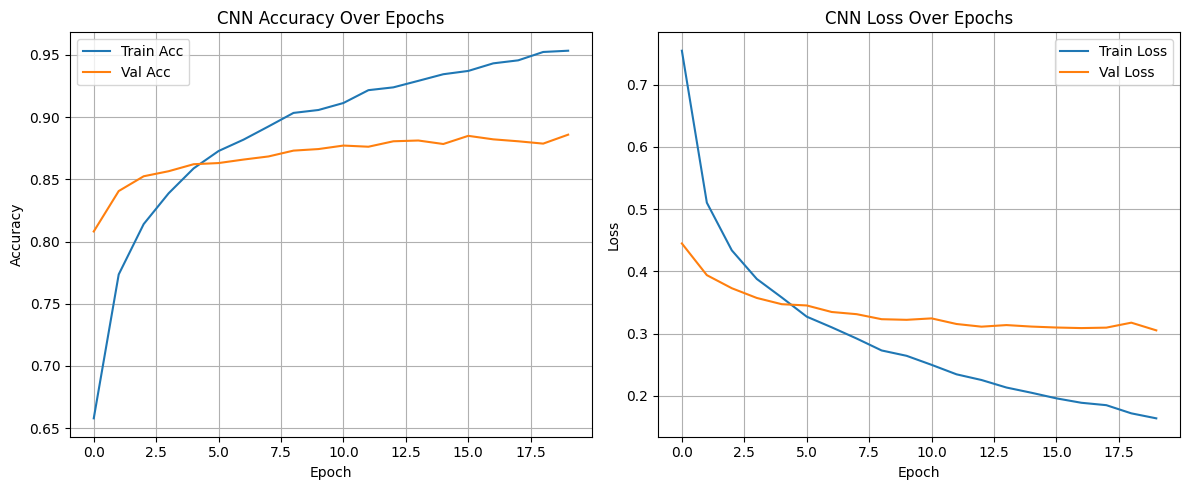

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()